In [16]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns       
import pandas as pd                           # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from iminuit.cost import LeastSquares
from scipy import optimize
from scipy.stats import kstest
from scipy.stats import poisson

sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

In [17]:
r = np.random
r.seed(42)

save_plots = False   
N_points = 10000      # Number of random points to be produced!

xmin = 0.0
xmax = 2.0
N_bins = 30

def fx_2x(x) :
    # Normalization is N_points * binwidth:
    k = (xmax - xmin) / N_bins
    N = N_points * k
    return N*0.66262*(1-np.exp(-2*x))

In [18]:
N_try = 0
ymin = 0.0      # Minimum value the function will take!
ymax = 0.7      # Maximum value the function will take!
x_accepted = np.zeros(N_points)

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = r.uniform(xmin, xmax)  
        
        # Upper bound for function values:
        y_test = r.uniform(ymin, ymax)
        
        if (y_test < 0.66262*(1-np.exp(-2*x_test))):
            break
            
    x_accepted[i] = x_test

In [19]:
# Efficiency
eff = N_points / N_try                        

# Error on efficiency (binomial!)
eff_error = np.sqrt(eff * (1-eff) / N_try) 

# Integral
integral =  eff * (xmax-xmin) * (ymax-ymin)

# Error on integral
eintegral = eff_error * (xmax-xmin) * (ymax-ymin)  

print(f"\nIntegral of f(x) = x, x in [0, 1] is: \t {integral:7.4f} +- {eintegral:6.4f}")
print(f"The efficiency of the Accept/Reject method used here is: \t {eff:.2%} +/- {eff_error:.2%}")
# We normalized the function ahead of time, so we should hope to get a result consistent with unity!


Integral of f(x) = x, x in [0, 1] is: 	  1.0041 +- 0.0053
The efficiency of the Accept/Reject method used here is: 	 71.72% +/- 0.38%


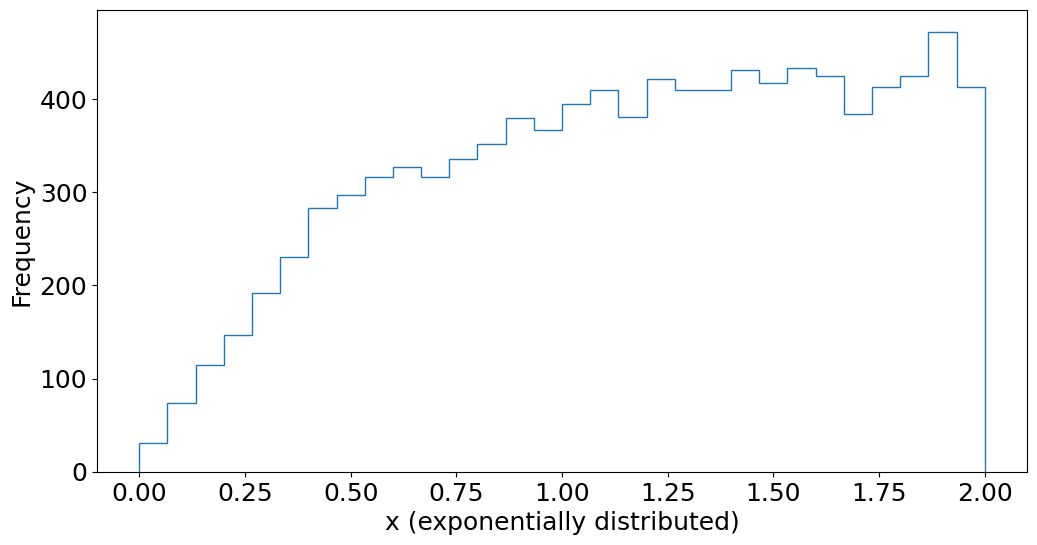

In [20]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.hist(x_accepted, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
ax2.set(xlabel="x (exponentially distributed)", ylabel="Frequency", xlim=(xmin-0.1, xmax+0.1));

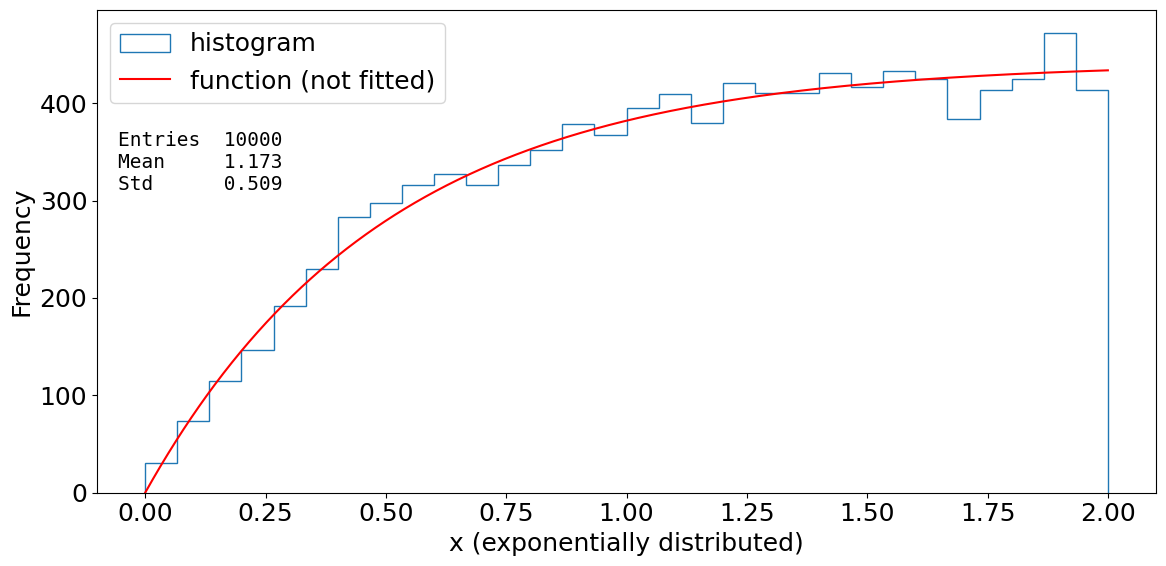

In [21]:
# Plot f(x)
x_axis2 = np.linspace(xmin, xmax, 1000)
y_axis2 = fx_2x(x_axis2)
ax2.plot(x_axis2, y_axis2, 'r-', label='function (not fitted)')

# Define the figure text
d2 = {'Entries': len(x_accepted),
      'Mean': x_accepted.mean(),
      'Std': x_accepted.std(ddof=1),
    }

# Add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.75, text2, ax2, fontsize=14)

# Add legend
ax2.legend(loc='best')
fig2.tight_layout()

# Save figure
if save_plots: 
    fig2.savefig("Hist_2x_AcceptRejectMethod.pdf", dpi=600)
    
# Show the figure
fig2

In [22]:
def gauss_fit(x,a,N):
    return  N*(0.66262*(1-np.exp(-a*x)))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_accepted, bins=N_bins)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
sy = sy[y>0]
y = y[y>0]

chi2fit = Chi2Regression(gauss_fit, x, y, sy)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

minuit_chi2 = Minuit(chi2fit,a=2, N=20)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits

chi2_value = minuit_chi2.fval
N_NotEmptyBin = np.sum(y>0)
Ndof_value = N_NotEmptyBin - len(minuit_chi2.parameters)

minuit_chi2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.04                      │              Nfcn = 86               │
│ EDM = 8.5e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    2.0    │    0.1    │            │            │         │         │       │
│ 1 │ N    │    662    │    12     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       N │
├───┼─────────────────┤
│ a │ 0.00912  -0.911 │
│ N │  -0.911     135 │
└───┴─────────────────┘

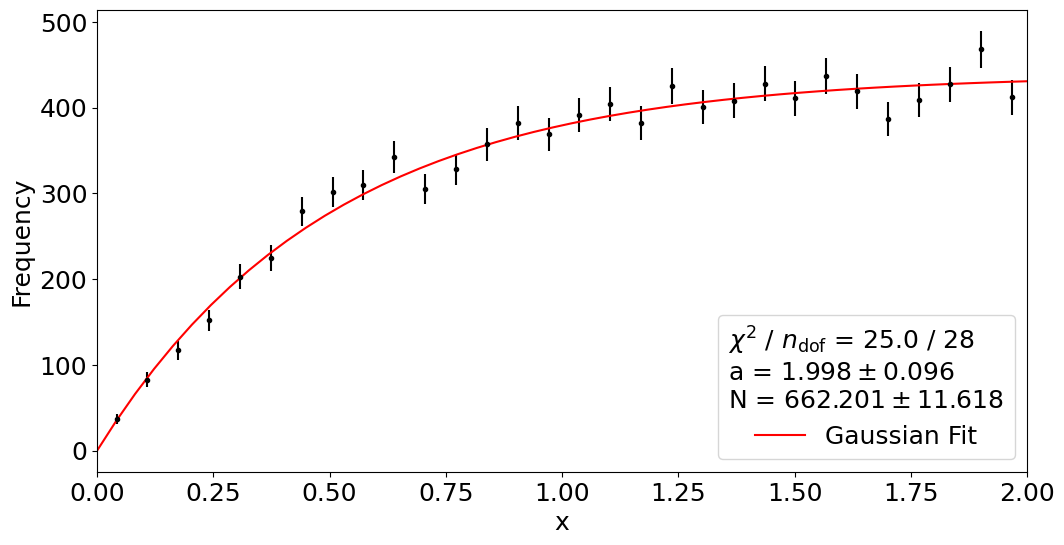

In [23]:

fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {minuit_chi2.fval:.1f} / {len(x) - minuit_chi2.nfit}"]
for p, v, e in zip(minuit_chi2.parameters, minuit_chi2.values, minuit_chi2.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(x,y,sy,fmt ='.', color = 'Black')
ax.plot(np.linspace(0,2), gauss_fit(np.linspace(0,2),*minuit_chi2.values),label = 'Gaussian Fit', color = 'Red')
ax.set_xlim(0,2)
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));


In [24]:
stats.chi2.sf(16.9,Ndof_value)

0.9505381238092354

In [33]:
t = []
for j in range(1000):
	r_val = np.sum(np.random.choice(x_accepted, 5))
	t.append(r_val)
t = np.array(t)
print(len(t))

1000


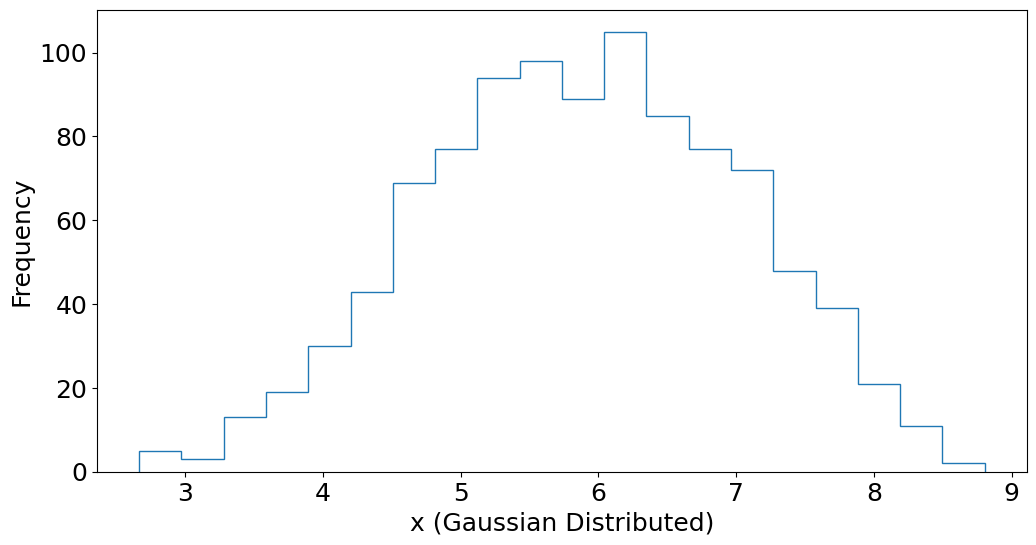

In [34]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.hist(t, bins=20, histtype='step', label='histogram' )
ax2.set(xlabel="x (Gaussian Distributed)", ylabel="Frequency");

In [35]:
def gauss_fit(x,sigma, mu, N):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(t, bins=N_bins)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
sy = sy[y>0]
y = y[y>0]

chi2fit = Chi2Regression(gauss_fit, x, y, sy)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

minuit_chi2 = Minuit(chi2fit,sigma=1, mu = 6, N =100)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()

chi2_value = minuit_chi2.fval
N_NotEmptyBin = np.sum(y>0)
Ndof_value = N_NotEmptyBin - len(minuit_chi2.parameters)

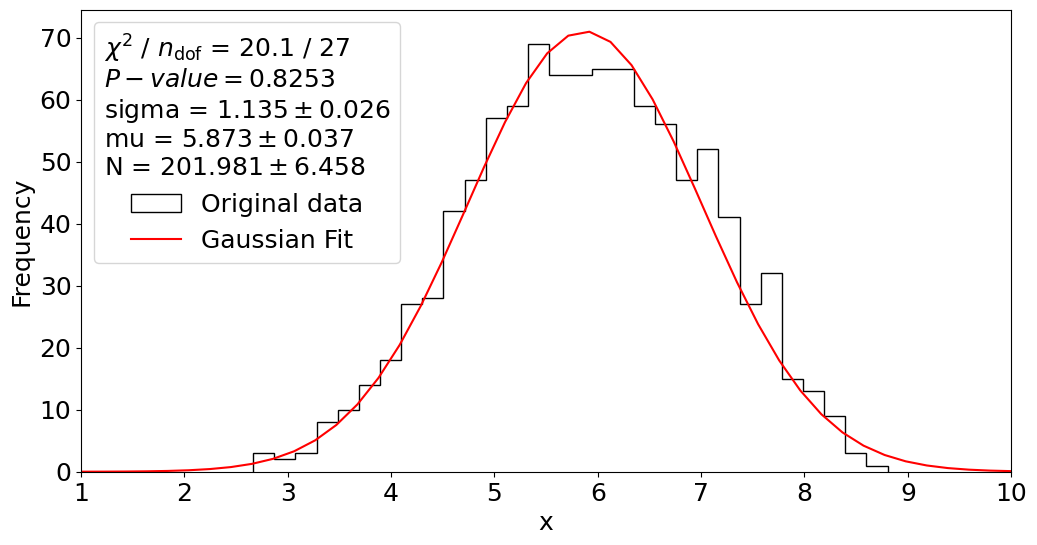

In [36]:
fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {minuit_chi2.fval:.1f} / {len(x) - minuit_chi2.nfit}",f"$P-value = {np.round(stats.chi2.sf(chi2_value,Ndof_value),4)}$"]
for p, v, e in zip(minuit_chi2.parameters, minuit_chi2.values, minuit_chi2.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(t, bins=N_bins, histtype='step', label='Original data', color = 'Black')
ax.errorbar(np.linspace(0,10), gauss_fit(np.linspace(0,10),*minuit_chi2.values),label = 'Gaussian Fit', color = 'Red')
ax.set_xlim(1,10)
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));